In [1]:
from microstruktur.signal_models import dispersed_models, gaussian_models
from microstruktur.core import modeling_framework, acquisition_scheme
from microstruktur.utils import utils
import matplotlib.pyplot as plt
%matplotlib inline

# Synthetic Experiment

In [2]:
from microstruktur.data import saved_acquisition_schemes, saved_data
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

## Get an intial guess for orientation using Dipy's DTI

In [3]:
from dipy.reconst import dti

gtab = acquisition_scheme.gtab_mipy2dipy(scheme)
tenmod = dti.TensorModel(gtab)
tenfit_parallel = tenmod.fit(synthetic_data_parallel.signal_attenuation)
tenfit_dispersed = tenmod.fit(synthetic_data_dispersed.signal_attenuation)

In [4]:
R_parallel = tenfit_parallel.evecs
R_dispersed = tenfit_dispersed.evecs

In [5]:
mu_par, psi_par = utils.R2mu_psi(R_parallel)
mu_disp, psi_disp = utils.R2mu_psi(R_dispersed)

## Generate NODDI-Bingham model

In [6]:
from microstruktur.utils.utils import parameter_equality, T1_tortuosity

ball = gaussian_models.G3Ball()
dispersed_stick = dispersed_models.SD2C1BinghamDispersedStick()
dispersed_zeppelin = dispersed_models.SD2G4BinghamDispersedZeppelin()

parameter_links = [
    (  # tortuosity assumption
        dispersed_zeppelin, 'lambda_perp',
        T1_tortuosity, [
            (None, 'partial_volume_1'),
            (None, 'partial_volume_2'),
            (dispersed_stick, 'lambda_par')
        ]
    ),
    (  # equal parallel diffusivities
         dispersed_zeppelin, 'lambda_par',
         parameter_equality, [
            (dispersed_stick, 'lambda_par')
        ]
     ),
    (  # equal dispersion
         dispersed_zeppelin, 'kappa',
         parameter_equality, [
            (dispersed_stick, 'kappa')
        ]
     ),
    (  # equal orientation
         dispersed_zeppelin, 'mu',
         parameter_equality, [
            (dispersed_stick, 'mu')
        ]
     ),
    (  # equal secondary dispersion
         dispersed_zeppelin, 'beta',
         parameter_equality, [
            (dispersed_stick, 'beta')
        ]
     ),
    (  # equal secondary dispersion orientation
         dispersed_zeppelin, 'psi',
         parameter_equality, [
            (dispersed_stick, 'psi')
        ]
     )
]


NODDI_bingham_mod = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme,
    models=[ball, dispersed_stick, dispersed_zeppelin],
    parameter_links=parameter_links
)

# Fix parallel diffusivity and isotropic diffusivity
NODDI_bingham_mod.optimized_parameters['SD2C1BinghamDispersedStick_1_lambda_par'] = False
NODDI_bingham_mod.optimized_parameters['G3Ball_1_lambda_iso'] = False

## Fit NODDI to data

In [7]:
param_parallel_x0 = NODDI_bingham_mod.parameter_initial_guess_to_parameter_vector(
    SD2C1BinghamDispersedStick_1_mu=mu_par,
    SD2C1BinghamDispersedStick_1_beta=0.,
    SD2C1BinghamDispersedStick_1_psi=psi_par,
    SD2C1BinghamDispersedStick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)
param_dispersed_x0 = NODDI_bingham_mod.parameter_initial_guess_to_parameter_vector(
    SD2C1BinghamDispersedStick_1_mu=mu_disp,
    SD2C1BinghamDispersedStick_1_beta=0.,
    SD2C1BinghamDispersedStick_1_psi=psi_disp,
    SD2C1BinghamDispersedStick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)

SD2C1BinghamDispersedStick_1_mu successfully set.
SD2C1BinghamDispersedStick_1_beta successfully set.
SD2C1BinghamDispersedStick_1_lambda_par successfully set.
G3Ball_1_lambda_iso successfully set.
SD2C1BinghamDispersedStick_1_psi successfully set.
SD2C1BinghamDispersedStick_1_mu successfully set.
SD2C1BinghamDispersedStick_1_beta successfully set.
SD2C1BinghamDispersedStick_1_lambda_par successfully set.
G3Ball_1_lambda_iso successfully set.
SD2C1BinghamDispersedStick_1_psi successfully set.


In [10]:
# fitting to parallel (undispersed) data varying diffusivity D=[1.7, 2.0, 2.3]
NODDI_fit = NODDI_bingham_mod.fit(
    synthetic_data_parallel.signal_attenuation,
    parameter_initial_guess=param_parallel_x0)

# fitting to dispersed data varying diffusivity D=[1.7, 2.0, 2.3]
NODDI_fit_dispersed = NODDI_bingham_mod.fit(
    synthetic_data_dispersed.signal_attenuation,
    parameter_initial_guess=param_dispersed_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 114.841692924 seconds.
Average of 0.348005130074 seconds per voxel.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 1555.03903294 seconds.
Average of 0.523582165972 seconds per voxel.


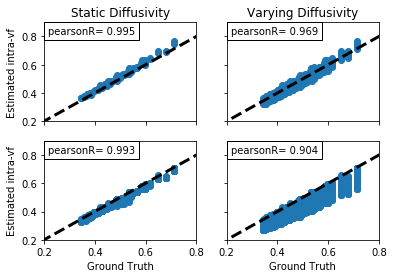

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

saved_data.visualize_correlation_camino_and_estimated_fractions(
    NODDI_fit.fitted_parameters['partial_volume_1'].squeeze(),
    NODDI_fit_dispersed.fitted_parameters['partial_volume_1'].squeeze())

# Human Connectome Project Example

In [12]:
from microstruktur.data import saved_data
data = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


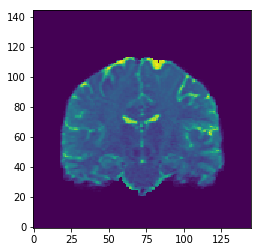

In [13]:
plt.imshow(data[:,0,:,0].T, origin=True)

## Get an intial guess for orientation using Dipy's DTI

In [14]:
tenmod = dti.TensorModel(gtab)
tenfit = tenmod.fit(data, mask=data[..., 0]>0)

In [15]:
R = tenfit.evecs
mu, psi = utils.R2mu_psi(R)

param_x0 = NODDI_bingham_mod.parameter_initial_guess_to_parameter_vector(
    SD2C1BinghamDispersedStick_1_mu=mu,
    SD2C1BinghamDispersedStick_1_lambda_par=1.7e-9,
    SD2C1BinghamDispersedStick_1_beta=0.,
    SD2C1BinghamDispersedStick_1_psi=psi,
    G3Ball_1_lambda_iso=3.0e-9
)

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/utils/utils.py:341: RuntimeWarning: invalid value encountered in divide
  mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta


SD2C1BinghamDispersedStick_1_mu successfully set.
SD2C1BinghamDispersedStick_1_beta successfully set.
SD2C1BinghamDispersedStick_1_lambda_par successfully set.
G3Ball_1_lambda_iso successfully set.
SD2C1BinghamDispersedStick_1_psi successfully set.


## Fit NODDI to HCP data

In [16]:
NODDI_fit_hcp = NODDI_bingham_mod.fit(
    data=data, mask=data[..., 0]>0,
    parameter_initial_guess=param_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 3689.21872401 seconds.
Average of 0.450949605673 seconds per voxel.


## Visualize results

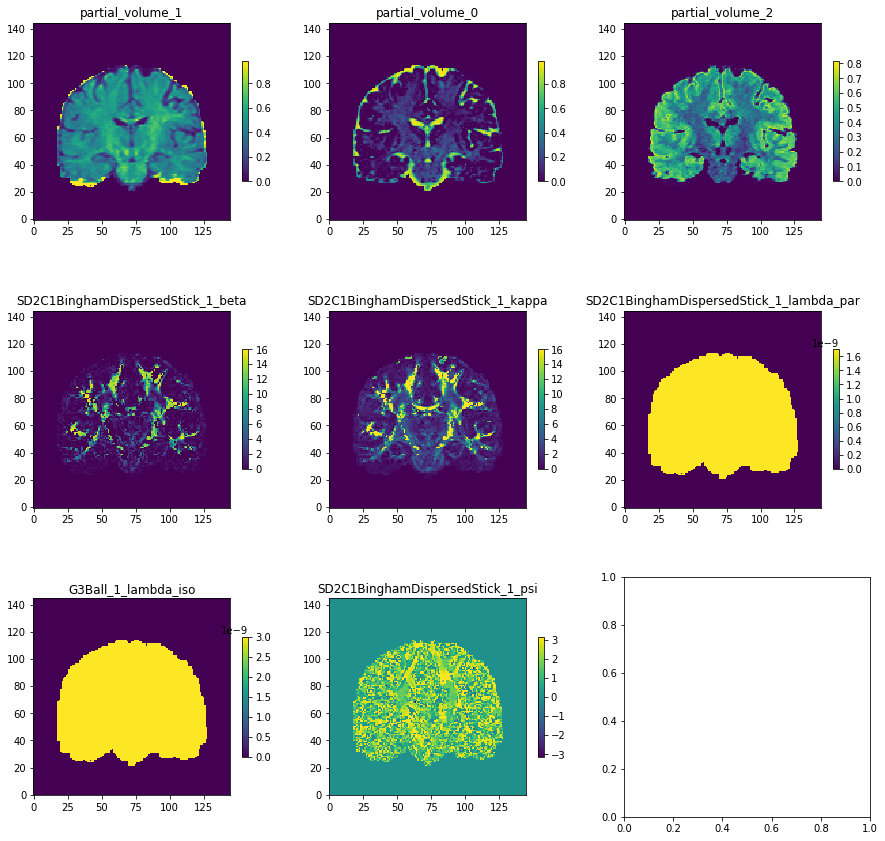

In [17]:
fitted_parameters = NODDI_fit_hcp.fitted_parameters

fig, axs = plt.subplots(3, 3, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

Notice that using this very simple model we get some familiar maps, where the Ball model takes the role of extra-axonal and CSF compartments, and the stick takes the intra-axonal compartment. 

Also notice that the maps are not completely smooth (especially lambda_par) as optimization can still fall in a local minima despite the brute force optimization. 

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated concentration $\kappa$ as background.

In [18]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = NODDI_fit_hcp.fod(sphere.vertices)

In [19]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

kappa_res = fitted_parameters['SD2C1BinghamDispersedStick_1_kappa']
kappa_res.shape
kappa_im = slicer(kappa_res[70:90,0, 70:90],interpolation='nearest', affine=affine, opacity=0.7)

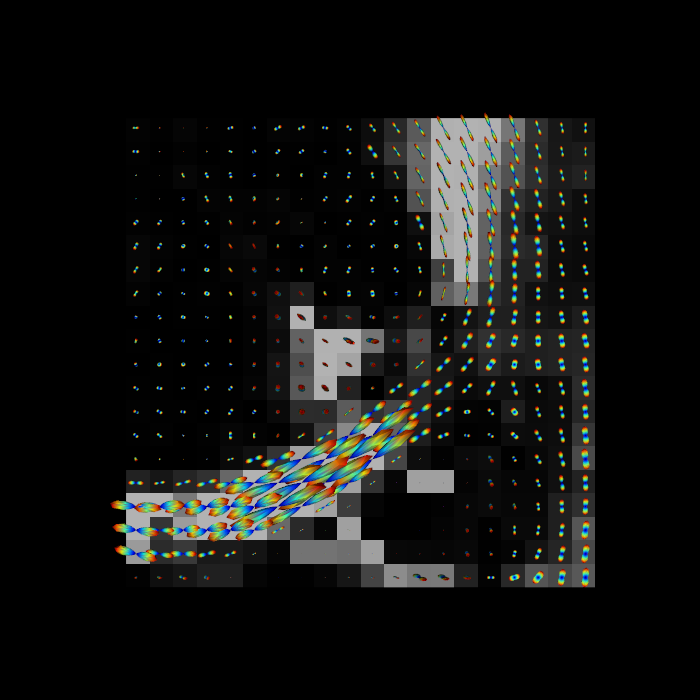

In [20]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, kappa_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows the concentration $\kappa$ of the Watson distribution. Notice it is high in the corpus callosum and lower in non-white matter areas. Also notice that in the CSF on the bottom you see very high $\kappa$, but it means nothing since the intra-axonal volume fraction is zero in these areas. Also notice that NODDI-Watson cannot estimate crossings, which are expected in the centrum semiovale on the right. This biases any comparison/estimation of volume fractions and concentrations in these areas.

In [21]:
from os import remove
remove('dipy.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:924: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:905: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


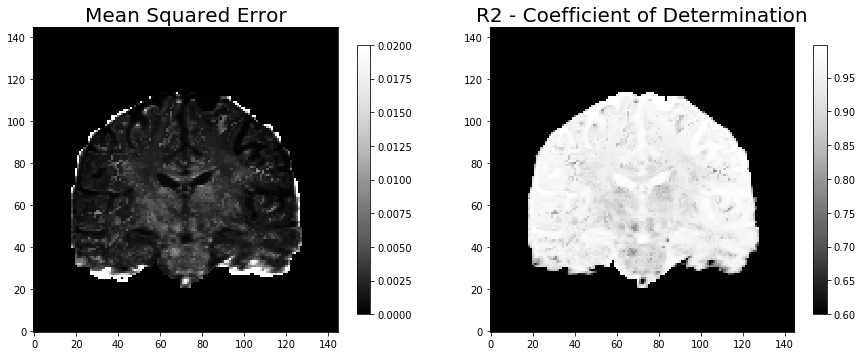

In [22]:
mse = NODDI_fit_hcp.mean_squared_error(data)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in Ball and Stick we can see clearly see the structure of the different brain areas. This means that Ball and Stick model cannot fit the diffusion equally well in all brian areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.